In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

Work with data, set number of features, classes and samples.

In [ ]:
people = fetch_lfw_people(min_faces_per_person=60, resize=0.4)

# Numpy array, ravelled face images
data = people.data 
num_of_samples, height, width = people.images.shape 
num_of_features = data.shape[1]

# Numpy array, labels associated to each face image (0-5748, correspond to the person IDs). 
target = people.target

# List of str, names matching the labels
target_names = people.target_names

# Number of labels
num_of_classes = target_names.shape[0]

print("Dataset description:")
desc = pd.DataFrame({'num_of_samples': [num_of_samples], 'num_of_features': [num_of_features], 'num_of_classes': [num_of_classes]})
desc.head()

Dataset description:


,num_of_samples,num_of_features,num_of_classes
0,1348,1850,8


Splitting and scaling the data to achieve better fitting.

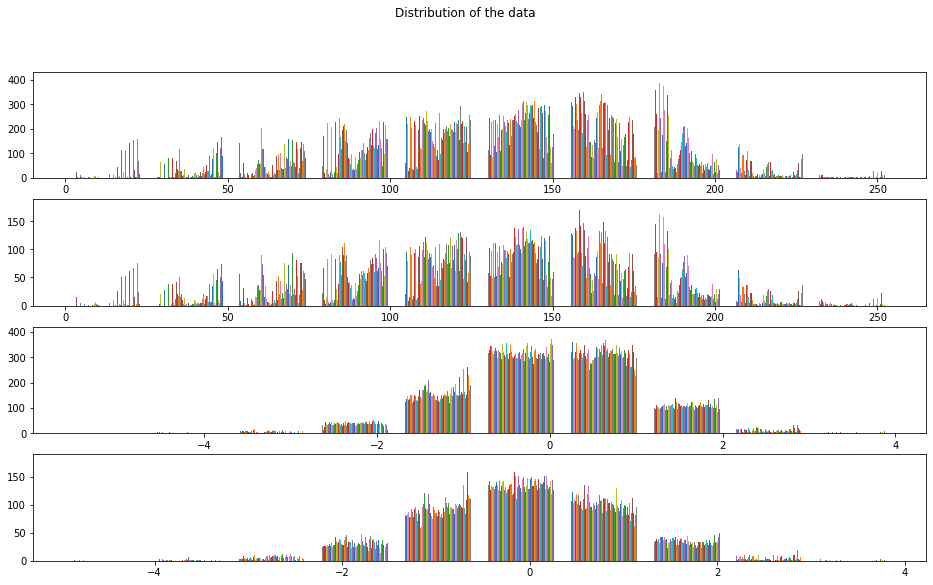

In [ ]:
# split data into parts for training and testing
train_data, test_data, target_train, target_test = train_test_split(data, target, test_size=0.3, random_state=42)

# use scaler to normalize data, to achive better fitting
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)


# plot data
fig, axs = plt.subplots(4, figsize=(16,9))
fig.suptitle('Distribution of the data')
axs[0].hist(train_data)
axs[1].hist(test_data)
axs[2].hist(train_data_scaled)
axs[3].hist(test_data_scaled)
plt.show()

In [ ]:
# apply principal component analysis
num_of_components = 200
pca_transform = PCA(n_components=num_of_components, svd_solver="auto", whiten = True).fit(train_data)
eigenfaces = pca_transform.components_.reshape((num_of_components, height, width))

train_data_pca = pca_transform.transform(train_data)
test_data_pca = pca_transform.transform(test_data)

                   precision    recall  f1-score   support

     Ariel Sharon       0.54      0.82      0.65        17
     Colin Powell       0.78      0.88      0.83        84
  Donald Rumsfeld       0.80      0.78      0.79        36
    George W Bush       0.86      0.84      0.85       146
Gerhard Schroeder       0.85      0.79      0.81        28
      Hugo Chavez       0.89      0.63      0.74        27
Junichiro Koizumi       0.88      0.88      0.88        16
       Tony Blair       0.84      0.75      0.79        51

         accuracy                           0.81       405
        macro avg       0.80      0.80      0.79       405
     weighted avg       0.82      0.81      0.82       405



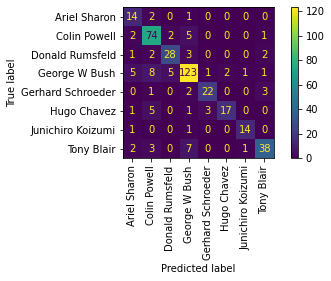

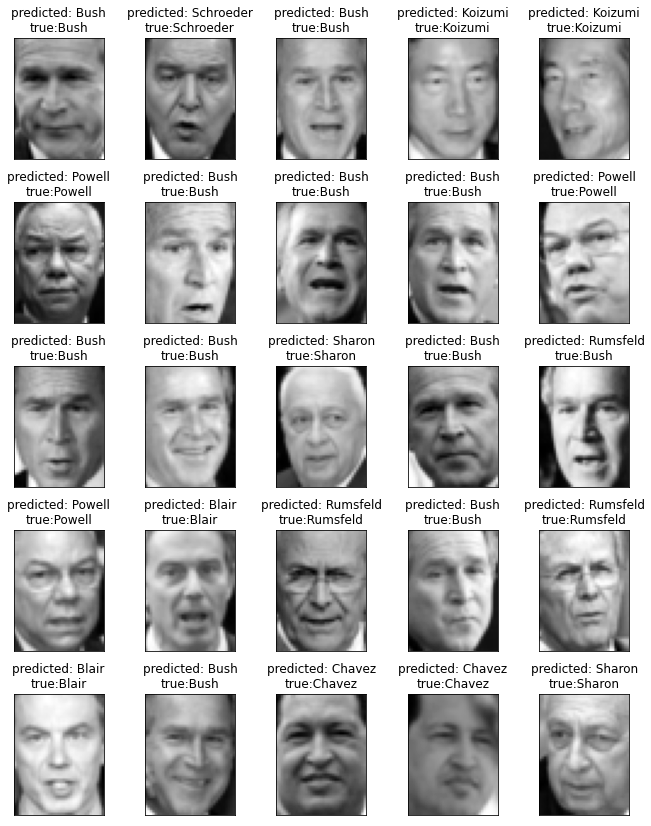

In [ ]:
# set the parameter distridution
gamma_range = loguniform(1e-4, 1e-1)
C_range = loguniform(1e3, 1e5)
parameter_grid = dict(gamma=gamma_range, C=C_range)

# apply a SVM classification model and fit data to the training set
classification = RandomizedSearchCV(SVC(kernel="rbf", class_weight="balanced"), parameter_grid, n_iter=15)
classification = classification.fit(train_data_pca, target_train)

# Predicting people's names on the test set
prediction = classification.predict(test_data_pca)

# ploting results
print(classification_report(target_test, prediction, target_names=target_names))
ConfusionMatrixDisplay.from_estimator(classification, test_data_pca, target_test, display_labels=target_names, xticks_rotation="vertical")
plt.tight_layout()
plt.show()

prediction_titles = []
for i in range(prediction.shape[0]):
    predicted_name = target_names[prediction[i]].rsplit(" ", 1)[-1]
    actual_name = target_names[target_test[i]].rsplit(" ", 1)[-1]
    prediction_titles.append(f"predicted: {predicted_name}\ntrue:{actual_name}")

columns = 5
rows = 5
plt.figure(figsize=(1.8 * columns, 2.4 * rows))
plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)

for i in range(rows * columns):
    plt.subplot(rows, columns, i + 1)
    plt.imshow(test_data[i].reshape((height, width)), cmap=plt.cm.gray)
    plt.title(prediction_titles[i], size=12)
    plt.xticks(())
    plt.yticks(())


## Conclusion
According to obtained results, we can say the eigenfaces algorithm works well on small dataset. The accuracy of the prediction is pretty high. 